In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from scipy.stats import bootstrap
import numpy as np

In [2]:
DATA_DIR = Path("../data/")
RESULTS_DIR = DATA_DIR / "classification/evaluation_results"

In [3]:
def get_truthful_ids() -> set[int]:
    human_reviews = pd.read_csv(
        DATA_DIR / "human" / "review_data_preprocessed.csv", index_col="id"
    )
    truthful_ids = set(
        human_reviews.loc[lambda df: df.veracity_label == "truthful"].index
    )

    return truthful_ids


TRUTHFUL_IDS = get_truthful_ids()

In [4]:
def caluclate_metrics(llm_data: pd.DataFrame, human_data: pd.DataFrame) -> pd.Series:
    human_data = human_data.loc[lambda df: df.review_id.isin(llm_data.review_id)]
    data = pd.concat([llm_data, human_data], ignore_index=True)

    return pd.Series(
        {
            "accuracy": accuracy_score(data.label, data.predictions),
            "precision": precision_score(data.label, data.predictions, pos_label="llm"),
            "recall": recall_score(data.label, data.predictions, pos_label="llm"),
            "f1": f1_score(data.label, data.predictions, pos_label="llm"),
        }
    )


def print_confidence_intervals(metrics):
    ci = bootstrap(
        (metrics.values,),
        statistic=np.mean,
        random_state=42,
        axis=0,
    ).confidence_interval
    print(f"CI low: {ci.low}")
    print(f"CI high: {ci.high}")


def load_results(model: str, condition_name: str) -> pd.DataFrame:

    results = list()

    for i in range(5):
        problem_name = f"{condition_name}_{i}"

        result_i = pd.read_csv(
            RESULTS_DIR / model / problem_name / "evaluation_results.csv"
        ).assign(split=i)
        results.append(result_i)

    results = pd.concat(results, ignore_index=True)

    return results


def test_set_filter(df: pd.DataFrame) -> pd.Series:
    is_truthful = df.review_id.isin(TRUTHFUL_IDS)
    is_llm_task = (df.source == "openai") & (df.strategy == "minimal")
    return (is_llm_task) & is_truthful


def get_metrics(results: pd.DataFrame):
    human_truthful = results.loc[
        lambda df: (df.label == "human") & (df.review_id.isin(TRUTHFUL_IDS))
    ]

    metrics = (
        results.loc[test_set_filter]
        .groupby("split")
        .apply(caluclate_metrics, human_data=human_truthful)
    )

    return metrics

## RoBERTa

In [6]:
roberta_results = load_results("bert", "truthful_openai_minimal")
roberta_metrics = get_metrics(roberta_results)
roberta_metrics

accuracy  precision    recall        f1
split                                         
0      1.000000   1.000000  1.000000  1.000000
1      0.990741   1.000000  0.981481  0.990654
2      0.995370   0.990826  1.000000  0.995392
3      0.995370   0.990826  1.000000  0.995392
4      1.000000   1.000000  1.000000  1.000000

In [7]:
roberta_metrics.mean()

accuracy     0.996296
precision    0.996330
recall       0.996296
f1           0.996288
dtype: float64

In [8]:
print_confidence_intervals(roberta_metrics)

CI low: [0.99259259 0.99266055 0.98518519 0.99254921]
CI high: [0.99907407 1.         1.         0.99907834]


## SetFit

In [9]:
setfit_results = load_results("setfit", "truthful_openai_minimal")
setfit_metrics = get_metrics(setfit_results)
setfit_metrics

accuracy  precision    recall        f1
split                                         
0       1.00000   1.000000  1.000000  1.000000
1       1.00000   1.000000  1.000000  1.000000
2       0.99537   0.990826  1.000000  0.995392
3       0.99537   1.000000  0.990741  0.995349
4       1.00000   1.000000  1.000000  1.000000

In [10]:
setfit_metrics.mean()

accuracy     0.998148
precision    0.998165
recall       0.998148
f1           0.998148
dtype: float64

In [11]:
print_confidence_intervals(setfit_metrics)

CI low: [0.9962963  0.99266055 0.99259259 0.99628764]
CI high: [1. 1. 1. 1.]


<Axes: xlabel='metric', ylabel='value'>

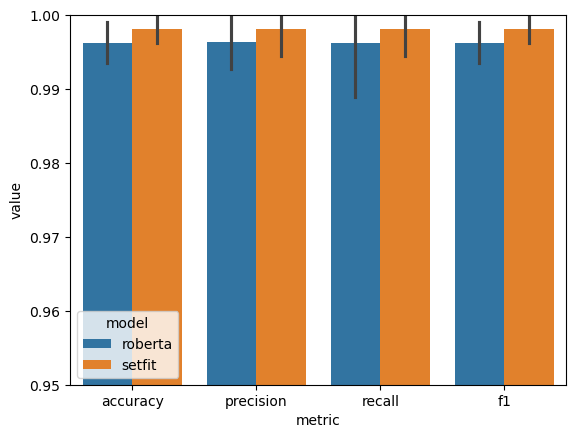

In [12]:
metrics = pd.concat(
    [
        roberta_metrics.melt(var_name="metric").assign(model="roberta"),
        setfit_metrics.melt(var_name="metric").assign(model="setfit"),
    ]
)
ax = sns.barplot(data=metrics, x="metric", y="value", hue="model")
ax.set_ylim(0.95, 1)
ax